<a href="https://colab.research.google.com/github/mapaloCat/Traffic-Sign-Detection-System/blob/master/02_retrain_binary_detector_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The German Traffic Sign Benchmark - Data Preparation

Collaborator 1: Panagiotis Michalopoulos

Collaborator 2: Filip Finfando

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!wget -c https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

--2020-02-21 21:54:15--  https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  10.7MB/s    in 2m 31s  

2020-02-21 21:56:47 (10.5 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.

In [3]:
# use those numbers to change range in the next cell
! wc -l 'drive/My Drive/data/bin_labels_sorted.txt'
! grep "00600.ppm" -B 5 -A 5 -m 1 'drive/My Drive/data/bin_labels_sorted.txt' --line-number

20554 drive/My Drive/data/bin_labels_sorted.txt
13566-00599.ppm;823;393;861;416;-1
13567-00599.ppm;827;392;848;413;-1
13568-00599.ppm;879;342;935;393;-1
13569-00599.ppm;922;336;954;359;-1
13570-00599.ppm;961;328;1011;391;-1
13571:00600.ppm;105;425;139;453;-1
13572-00600.ppm;116;435;154;472;-1
13573-00600.ppm;12;426;71;496;-1
13574-00600.ppm;124;422;148;456;-1
13575-00600.ppm;1;423;97;512;-1
13576-00600.ppm;151;459;183;479;-1


In [0]:
number_of_samples = 20554
split_at = 13571

In [5]:
# use those numbers to change range in the next cell
! wc -l 'drive/My Drive/data/bin_labels_retrain_sorted.txt'
! grep "00599.ppm" -B 5 -A 5 -m 1 'drive/My Drive/data/bin_labels_retrain_sorted.txt' --line-number

2274 drive/My Drive/data/bin_labels_retrain_sorted.txt
2267-00595.ppm;4;286;34;314;0
2268-00596.ppm;851;289;947;339;0
2269-00596.ppm;876;374;904;397;0
2270-00596.ppm;982;326;1020;359;0
2271-00597.ppm;723;390;760;424;0
2272:00599.ppm;524;334;542;359;1
2273-00599.ppm;525;340;541;357;1
2274-00599.ppm;525;340;541;368;1


In [0]:
no_retrain_images = 2274

In [0]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (96, 96)

# Function for reading the images
def readImages(rootpath, images_range, signs_range, datapath, scaled):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        # image_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        # # equalize the histogram of the Y channel
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        # image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
        # # convert the YUV image back to RGB format
        # img = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(datapath, delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        if scaled:
          scale = 1
        else:
          scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [0]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,no_retrain_images), 'drive/My Drive/data/bin_labels_retrain_sorted.txt', True)
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(split_at,number_of_samples), 'drive/My Drive/data/bin_labels_sorted.txt', True)

['0' '1']
[[   0    1]
 [ 423 1851]]


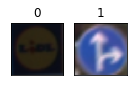

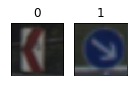

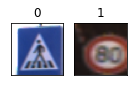

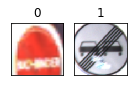

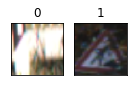

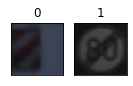

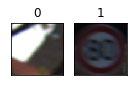

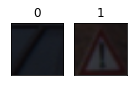

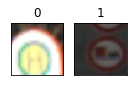

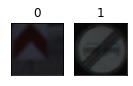

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
print(class_names)

ue, ce = np.unique(np.array(train_labels).astype('int32'), return_counts = True)
print(np.asarray((ue, ce)))

for r in range(10):
    fig = plt.figure(figsize=(10,10))
    for i in range(num_classes):
        ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
        ax.set_title(class_names[i])
        indices = np.where(np.isin(train_labels, class_names[i]))[0]
        plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
    plt.show()

In [0]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)

## Data Augmentation

In [0]:
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform

def rotate_image(image, max_angle =10):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=96, width=96):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans
    
def projection_transform(image, max_warp=0.8, height=96, width=96):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    

def transform_image(image, max_angle=10, max_trans=5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

    
def augment_and_balance_data(X_train, y_train, no_examples_per_class):
    
    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    n_classes = len(class_counts)
    #print(n_classes)
    height, width, channels = X_train[0].shape
    
    
    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = np.int32)
    

    #for c, count in zip(range(n_classes), class_counts):
    for c, count in zip(classes.astype(int), class_counts):
      ##Copy over the current data for the given class
      X_orig = X_train[y_train == c]
      #print(X_orig.shape)
      y_orig = y_train[y_train == c]
      #print(y_orig.shape)
      ##Add original data to the new dataset
      X_balance = np.append(X_balance, X_orig, axis=0)
      print(c,count)
      
      # if count >= no_examples_per_class:
      #   temp_X = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      # else:
      #   temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      #   #print(n_examples-count)
      #   for i in range(n_examples - count):
      #     #print(i%count)
      #     temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels)) 

      temp_X = np.empty([n_examples, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
      for i in range(n_examples):
        temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))      
          
          
      X_balance = np.append(X_balance,temp_X, axis=0)
      n_added_ex = X_balance.shape[0] - y_balance.shape[0]
      y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =np.int32))
        
   
    return X_balance.astype(np.uint8), y_balance

[[   0    1]
 [ 423 1851]]


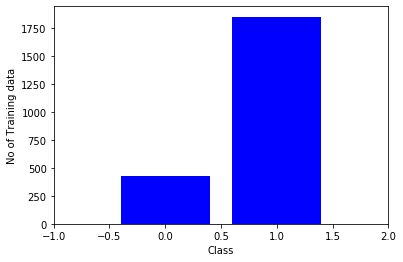

 
We can definitely see class bias issue as certain classes are under represented


In [12]:
# Checking for class bias before data augmentation 

unique_elements, counts_elements = np.unique(np.array(train_labels).astype('int32'), return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 2 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 2])

plt.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

[[  -1    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   22   23   24   25   26   28   29   30   31
    32   33   34   35   36   37   38   39   40   41   42]
 [6162   78   50   23   84   34    5   13   25   21   34   27   69   74
    25   11    2   10   22    8   19    7   18   14   13    4    4    3
    12    6    7   10    2    3   64    3    6    2    9]]


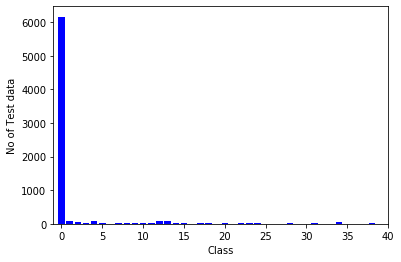

 
We can definitely see class bias issue as certain classes are under represented


In [13]:
# Checking for class bias in test set

unique_elements, counts_elements = np.unique(np.array(test_labels).astype('int32'), return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 39 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Test data')
plt.xlim([-1, 40])

plt.show()

print(" ")
print("We can definitely see class bias issue as certain classes are under represented")

In [14]:
no_examples_per_class = 423
X_train_aug, y_train_aug = augment_and_balance_data(np.array(train_signs), np.array(train_labels).astype('int32'), no_examples_per_class)
X_train_aug, y_train_aug = shuffle(X_train_aug, y_train_aug)

0 423
1 1851


[[   0    1]
 [ 846 2274]]


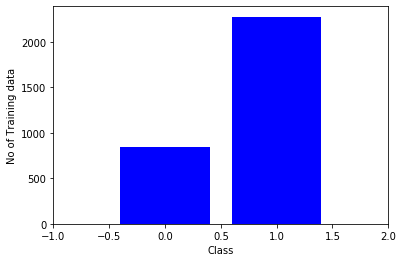

In [15]:
# Checking for class bias after data augmentation

unique_elements, counts_elements = np.unique(y_train_aug, return_counts = True)
print(np.asarray((unique_elements, counts_elements)))

plt.bar( np.arange( 2 ), counts_elements, align='center',color='blue' )
plt.xlabel('Class')
plt.ylabel('No of Training data')
plt.xlim([-1, 2])

plt.show()

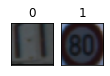

In [16]:
# Show examples from each class after data augmentation
class_names = np.unique(y_train_aug)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(y_train_aug, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(X_train_aug[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
import collections

# idxp = np.where(y_train_aug != -1)
# idxn = np.where(y_train_aug == -1)
# y_train_aug[idxn[0]] = 0
# y_train_aug[idxp[0]] = 1

# print(collections.Counter(y_train_aug))

idxp = [i for i,x in enumerate(test_labels) if x != '-1']
idxn = [i for i,x in enumerate(test_labels) if x == '-1']
test_labels = np.array(test_labels)
test_labels[np.array(idxn).astype('int')] = 0
test_labels[np.array(idxp).astype('int')] = 1

print(collections.Counter(test_labels))

num_classes = 2
print("num_classes: ", num_classes)

Counter({'0': 6162, '1': 821})
num_classes:  2


In [0]:
from sklearn.model_selection import train_test_split

tr_signs, va_signs, tr_labels, va_labels = train_test_split(X_train_aug, y_train_aug, test_size=0.2, random_state=42, stratify=y_train_aug)

In [0]:
tr_signs = np.array(tr_signs)
tr_labels = np.array(tr_labels)
va_signs = np.array(va_signs)
va_labels = np.array(va_labels)
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

temp_tr_labels = tr_labels

In [20]:
from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [0]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Retraining Model - Transfer Learning

In [22]:
## import the previously trained binary model and retrain
from keras.models import model_from_json
from keras.optimizers import Adam

json_file = open('drive/My Drive/models/bin_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
tlm = model_from_json(loaded_model_json)
# load weights into new model
tlm.load_weights("drive/My Drive/models/bin_model.h5")
print("Loaded binary model from disk")

opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
tlm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
tlm.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded binary model from disk


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 47, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   

In [0]:
# from keras.applications.xception import Xception
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
# from keras.models import Model
# from keras.optimizers import Adam

# baseline = Xception(weights='imagenet', input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3), include_top=False)

# x = baseline.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, use_bias=False)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, use_bias=False)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = Dropout(0.5)(x)

# predictions = Dense(num_classes, activation='softmax')(x)
# tlm = Model(inputs=baseline.input, outputs=predictions)

# # for i,layer in enumerate(tlm.layers):
# #   print(i,layer.name)  

# # print('\nnon-trainable')
# # for layer in baseline.layers[:116]:
# #     layer.trainable=False
# #     print(layer.name)

# # print('\ntrainable')
# # for layer in baseline.layers[116:]:
# #     layer.trainable=True
# #     print(layer.name)

# opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# tlm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
# tlm.summary()

In [23]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight("balanced", np.unique(temp_tr_labels), temp_tr_labels)

# class_weight[0] = 1
# class_weight[1] = 100

print(class_weight)

[1.84342688 0.68609126]


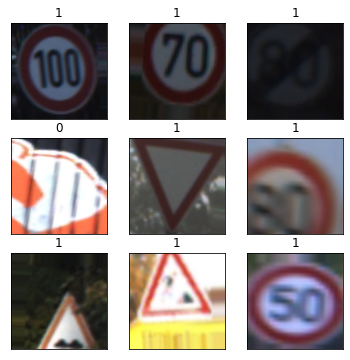

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/50
 - 20s - loss: 0.6051 - acc: 0.9259 - val_loss: 0.3783 - val_acc: 0.9615

Epoch 2/50
 - 8s - loss: 0.2900 - acc: 0.9427 - val_loss: 0.2433 - val_acc: 0.9663
Epoch 3/50
 - 8s - loss: 0.2576 - acc: 0.9451 - val_loss: 0.1341 - val_acc: 0.9696
Epoch 4/50
 - 8s - loss: 0.1679 - acc: 0.9523 - val_loss: 0.0591 - val_acc: 0.9760
Epoch 5/50
 - 8s - loss: 0.1298 - acc: 0.9619 - val_loss: 0.0502 - val_acc: 0.9776
Epoch 6/50
 - 8s - loss: 0.1186 - acc: 0.9728 - val_loss: 0.0438 - val_acc: 0.9840
Epoch 7/50
 - 8s - loss: 0.0981 - acc: 0.9716 - val_loss: 0.0398 - val_acc: 0.9840
Epoch 8/50
 - 8s - loss: 0.0749 - acc: 0.9744 - val_loss: 0.0360 - val_acc: 0.9856
Epoch 9/50
 - 8s - loss: 0.0611 - acc: 0.9800 - val_loss: 0.0325 - val_acc: 0.9872
Epoch 10/50
 - 8s - loss: 0.0445 - acc: 0.9848 - val_loss: 0.0283 - val_acc: 0.9904
Epoch 11/50
 - 8s - loss: 0.0630 - acc: 0.9828 - val_loss: 0.0276 - v

In [24]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

batch_size = 32
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')

datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.15,
                             shear_range=0.15,
                             rotation_range=10.)

datagen.fit(tr_signs, augment=True)

for x_batch, y_batch in datagen.flow(tr_signs, tr_labels, batch_size=9):
    # create a grid of 3x3 images
    fig = plt.figure(figsize=(6,6))
    for i in range(0, 9):
        ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
        ax.set_title(np.argmax(y_batch[i]))
        plt.imshow(cv2.cvtColor(x_batch[i], cv2.COLOR_BGR2RGB))
    # show the plot
    plt.show()
    break

train_steps = int(len(tr_signs) / batch_size)
valid_steps = int(len(va_signs) / batch_size)

data = tlm.fit_generator(datagen.flow(tr_signs, tr_labels, batch_size=batch_size),                              
                              epochs=50, 
                              steps_per_epoch=train_steps, 
                              verbose=2, 
                              validation_data=(va_signs, va_labels), 
                              validation_steps=valid_steps, 
                              callbacks=[tensorboard, early_stopping],
                              class_weight = class_weight)

start = time()
loss, acc = tlm.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('Transfer Learning model took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

## Plots and confusion matrix

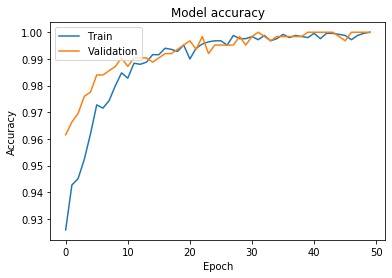

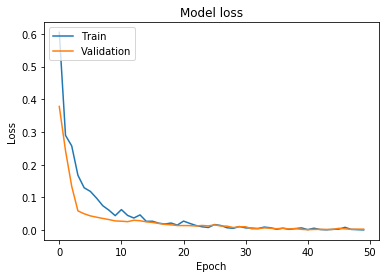

In [25]:
# Plot training & validation accuracy values
plt.plot(data.history['acc'])
plt.plot(data.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[6118   44]
 [   7  814]]


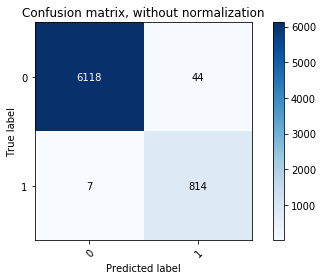

In [26]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(
    np.argmax(te_labels, axis=1), 
    np.argmax(tlm.predict(te_signs), axis=1), 
    classes=np.array([0,1]),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

In [27]:
from sklearn.metrics import average_precision_score, accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, confusion_matrix

te_labels_predicted = np.argmax(tlm.predict(te_signs), axis=1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.argmax(te_labels, axis=1), te_labels_predicted)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.argmax(te_labels, axis=1), te_labels_predicted)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.argmax(te_labels, axis=1), te_labels_predicted)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.argmax(te_labels, axis=1), te_labels_predicted)
print('F1 score: %f' % f1)
# ROC AUC
auc = roc_auc_score(np.argmax(te_labels, axis=1), tlm.predict(te_signs)[:,1])
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(np.argmax(te_labels, axis=1), te_labels_predicted)
print(matrix)

average_precision = average_precision_score(np.argmax(te_labels, axis=1), te_labels_predicted)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Accuracy: 0.992697
Precision: 0.948718
Recall: 0.991474
F1 score: 0.969625
ROC AUC: 0.998971
[[6118   44]
 [   7  814]]
Average precision-recall score: 0.94


In [0]:
# from sklearn.metrics import precision_recall_curve
# import matplotlib.pyplot as plt
# from inspect import signature

# precision, recall, _ = precision_recall_curve(np.argmax(te_labels, axis=1), te_labels_predicted)

# # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
# step_kwargs = ({'step': 'post'}
#                if 'step' in signature(plt.fill_between).parameters
#                else {})
# plt.step(recall, precision, color='b', alpha=0.2,
#          where='post')
# plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

## Perform tests and save model

In [0]:
import pickle
with open('drive/My Drive/models/test_pred.pickle', 'rb') as fp:
    test_pred = pickle.load(fp)

In [0]:
# from keras.models import model_from_json
# # load json and create model
# json_file = open('drive/My Drive/models/bin_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# tlm = model_from_json(loaded_model_json)
# # load weights into new model
# tlm.load_weights("drive/My Drive/models/bin_model.h5")
# print("Loaded binary model from disk")

In [0]:
train_images2, train_files2, train_signs2, train_bboxes2, train_labels2 = readImages('FullIJCNN2013', range(0,600), range(0,852), 'FullIJCNN2013/gt.txt', False)
test_images2, test_files2, test_signs2, test_bboxes2, test_labels2 = readImages('FullIJCNN2013', range(600,900), range(852,1213), 'FullIJCNN2013/gt.txt', False)

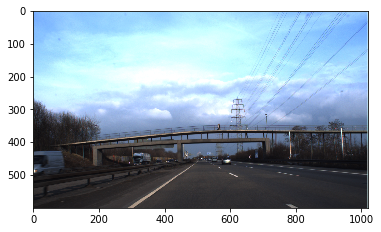

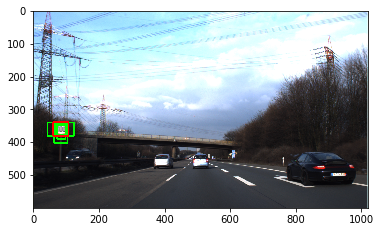

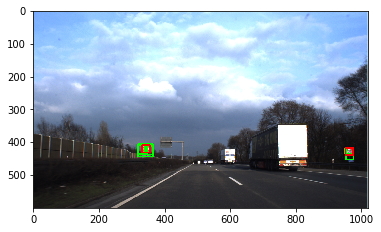

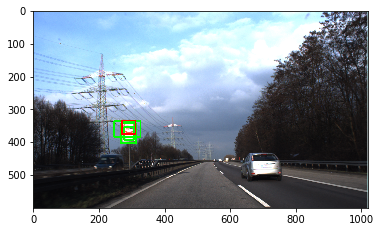

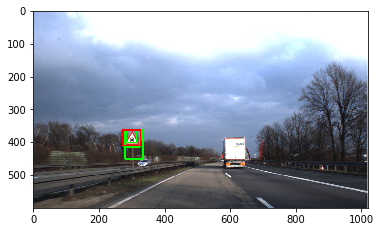

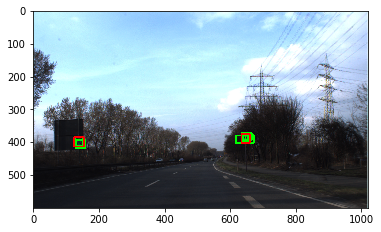

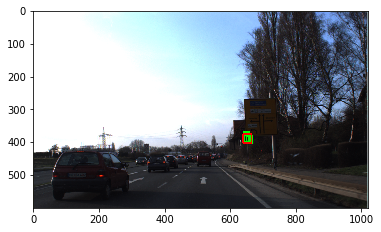

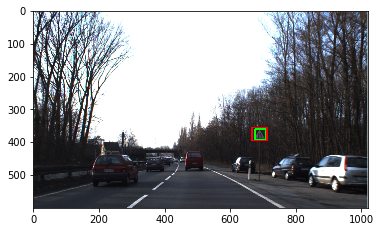

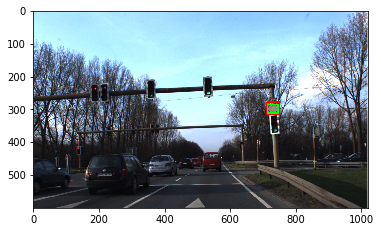

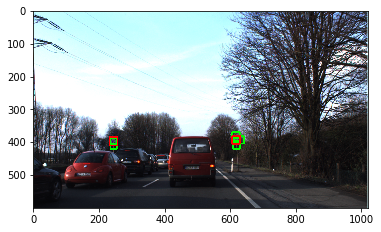

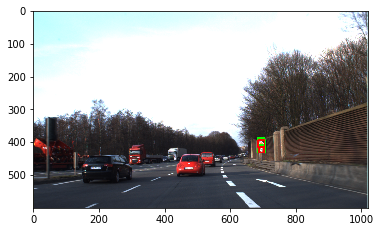

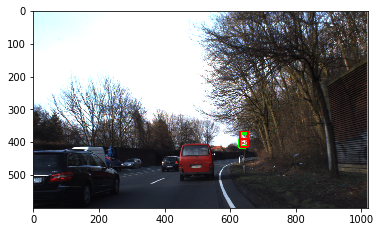

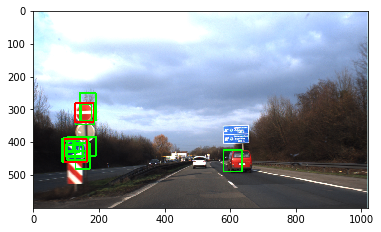

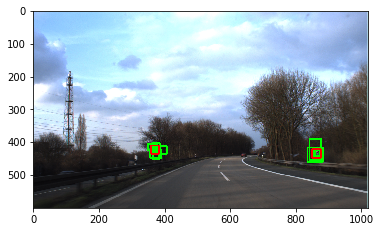

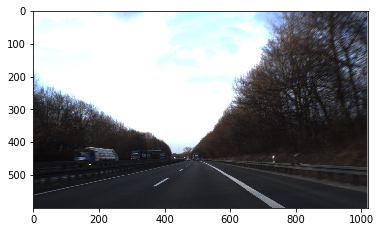

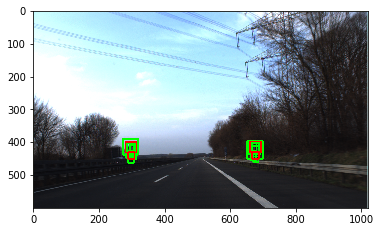

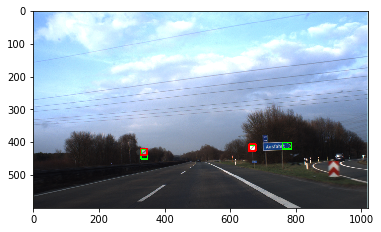

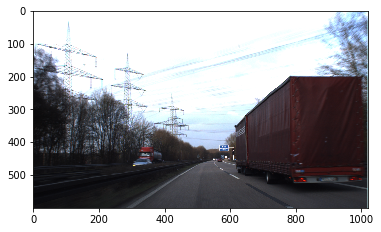

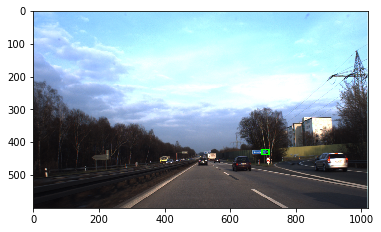

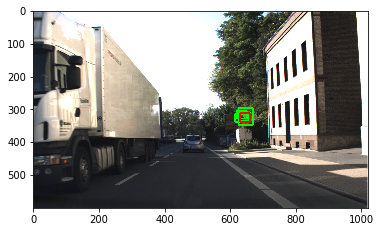

In [33]:
# run some tests
i=0

number_of_images = 20
number_of_boxes_to_draw = 1000

for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0][:number_of_boxes_to_draw]:  
        
        #filter some boxes before making predictions
        dx = int(bbox[0])-int(bbox[2])
        dy = int(bbox[1])-int(bbox[3])
        ratio = abs(dy/dx)
        if ratio<1:
            ratio=1/ratio
        if ratio>2 or abs(dx)>96 or abs(dy)>96:
            continue
        
        # make a prediction
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        SIGN_SIZE_CNN = (96, 96)
        roi_resized = cv2.resize(roi, SIGN_SIZE_CNN)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE_CNN[0],SIGN_SIZE_CNN[1],3])
        
        confidence = tlm.predict(roi_resized)
        if confidence[0][1] >= 0.5:
            # print(confidence)
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)       
          

    if filename in test_files2:
        for idx in [i for i, x in enumerate(test_files2) if x == filename]:
            bbox = test_bboxes2[idx]
            # print(filename)
            # print(bbox)
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,0,255), 3)           
            
    
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
    i+=1
    if i==number_of_images: break

In [34]:
# serialize model to JSON
model_json = tlm.to_json()
with open("drive/My Drive/models/bin_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
tlm.save_weights("drive/My Drive/models/bin_model.h5")
print("Saved model to disk")

Saved model to disk
